#### [KNN기반 Bream_Smelt 식별 모델]
- 데이터: 1000개 bream_smelt_best.csv
- 데이터셋
    * 피쳐: Weight, Length
    * 타겟: Species  

- 학습종류
    * 지도학습 => 분류: 2진분류
    * 알고리즘 => 최근접이웃 알고리즘 : 거리기반 -> 스케일링필수, 메모리 고려

In [1]:
## 로딩, 분석, 전처리 모듈
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib

## ML모델 / 전처리 모듈
from sklearn.preprocessing import StandardScaler, RobustScaler      ## 전처리
from sklearn.model_selection import train_test_split                ## 데이터셋 분리
from sklearn.neighbors import KNeighborsClassifier                  ## 알고리즘

[2] 데이터 확인 및 전처리 <hr>

In [2]:
## 데이터 불러오기
fishDF = pd.read_csv('../Data/bream_smelt.csv')

## [2-1] 데이터확인 
display(fishDF.head(3))
fishDF.info

,Species,Weight,Length
0,Bream,323.587836,28.928442
1,Bream,402.087382,32.901921
2,Bream,313.261134,26.439356


<bound method DataFrame.info of     Species      Weight     Length
0     Bream  323.587836  28.928442
1     Bream  402.087382  32.901921
2     Bream  313.261134  26.439356
3     Bream  404.993782  28.787494
4     Bream  510.314772  30.814356
..      ...         ...        ...
995   Smelt  165.750620  23.375497
996   Smelt  168.491839  24.124279
997   Smelt  280.215490  25.971405
998   Smelt  159.844916  24.872444
999   Smelt  414.212851  24.871804

[1000 rows x 3 columns]>

In [3]:
# ==================================================
## 컬럼별 기술통계 확인
# ==================================================
## -> Weight, Length 모두 음의 왜도, 왼쪽꼬리, 오른쪽 쏠림
fishDF.describe()

,Weight,Length
count,1000.000000,1000.000000
mean,442.173820,28.804592
std,133.075903,2.662829
min,31.946399,20.836311
25%,348.529298,27.031225
50%,455.379492,29.047167
75%,540.597538,30.555417
max,777.715958,35.606743


<Axes: title={'center': '컬럼별 분포'}>

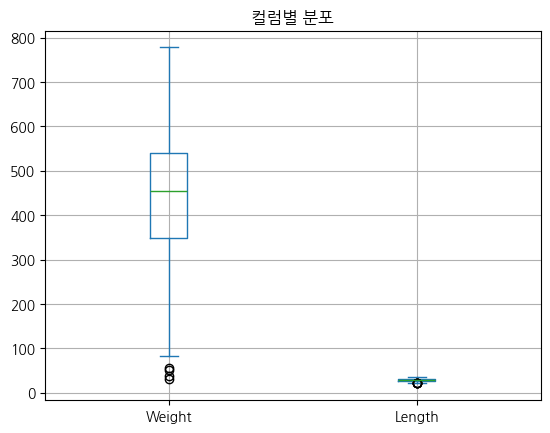

In [4]:
# ==================================================
## 결측치/중복값/이상치
# ==================================================
fishDF.isna().sum()             ## 0개

fishDF.duplicated().sum()       ## 0개

fishDF.plot(kind='box', title='컬럼별 분포', grid=True, )

In [5]:
## [2-2] 데이터 타입: 둘줄 컬럼 object <=> category
pd.options.mode.copy_on_write = True

fishDF.Species = fishDF.Species.astype('category')
fishDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Species  1000 non-null   category
 1   Weight   1000 non-null   float64 
 2   Length   1000 non-null   float64 
dtypes: category(1), float64(2)
memory usage: 16.9 KB


[3] 학습관련 전처리 및 준비 <hr>
- 피쳐와 타겟 분리
- 학습용과 테스트용 데이터셋 분리
- 1개의 Data 파일 경우 학습용 스케일러 생성 및 학습용/테스트용 적용

In [6]:
## [3-1] 피쳐와 타겟 분리
featureDF = fishDF[fishDF.columns[1:]]
targeSR   = fishDF[fishDF.columns[0]]

print(f'featureDF => {featureDF.shape} / {featureDF.ndim}D')
print(f'targeSR => {targeSR.shape} / {targeSR.ndim}D')

featureDF => (1000, 2) / 2D
targeSR => (1000,) / 1D


In [7]:
## [3-2] 학습용과 테스트용 데이터셋 분리
## x는 입력 => y는 출력 / train은 학습용 , test는 시험용
x_train, x_test, y_train, y_test = train_test_split(featureDF,
                                                    targeSR,
                                                    test_size=0.2,
                                                    random_state=42, ## 국룰임. -> 섞는걸 고정시키는거임
                                                    stratify=targeSR)

In [8]:
## [3-3] 수치형 피쳐들 스케일 조정 : 스케일러 생성 ★학습용으로 데이터셋으로 생성
stdScaler = StandardScaler()
stdScaler.fit(x_train)
print("모델 파라미터 :", stdScaler.mean_, stdScaler.var_, stdScaler.scale_)

## => 학습용/테스트용 데이터셋 스케일링 진행 => ★ndarray 타입
s_x_train = stdScaler.transform(x_train)
s_x_test = stdScaler.transform(x_test)

모델 파라미터 : [443.50053406  28.81580785] [1.80208683e+04 7.13685394e+00] [134.24182779   2.67148909]


[4] 학습 진행 => 기준성능 설정 : 학습 모델 기본값 그대로 학습 <hr>

In [9]:
## [4-0] 최적의 K값 찾기
best_t = []
best_s = []

for k in range(1,int((s_x_train.shape[0]+1)**(1/2))+1):
    # 모델 생성
    kModel = KNeighborsClassifier(n_neighbors=k)

    # 모델 학습
    kModel.fit(s_x_train, y_train) ## 학습은 학습용으로 하고

    # 성능 테스트 -> 테스트용
    score_t = kModel.score(s_x_test, y_test) ## 테스트는 테스트용으로 해야함. 학습용으로하면 작은값이 항상 높음 -> 문제가 똑같으니깐.
    best_t.append(score_t)
    # 성능 테스트 -> 공부용
    score_s = kModel.score(s_x_train, y_train) 
    best_s.append(score_s)
    

    # 출력
    print('점수 : ',score_t)
    print('점수 : ',score_s)
    print()
df = pd.DataFrame({'테스트용 테스트' :best_t, '공부용 테스트':best_s})
df['차이'] = abs(df['테스트용 테스트'] - df['공부용 테스트'])
df.sort_values(by=['차이','테스트용 테스트','공부용 테스트'], ascending=[True, False, False])
BEST_K = 7

점수 :  0.865
점수 :  1.0

점수 :  0.865
점수 :  0.91125

점수 :  0.905
점수 :  0.90875

점수 :  0.905
점수 :  0.895

점수 :  0.91
점수 :  0.905

점수 :  0.9
점수 :  0.90375

점수 :  0.915
점수 :  0.90125

점수 :  0.895
점수 :  0.90125

점수 :  0.905
점수 :  0.89875

점수 :  0.895
점수 :  0.90125

점수 :  0.9
점수 :  0.9025

점수 :  0.89
점수 :  0.9

점수 :  0.9
점수 :  0.90125

점수 :  0.905
점수 :  0.895

점수 :  0.895
점수 :  0.8975

점수 :  0.895
점수 :  0.895

점수 :  0.89
점수 :  0.8975

점수 :  0.9
점수 :  0.9

점수 :  0.885
점수 :  0.89875

점수 :  0.895
점수 :  0.89625

점수 :  0.885
점수 :  0.89875

점수 :  0.885
점수 :  0.89625

점수 :  0.88
점수 :  0.89625

점수 :  0.885
점수 :  0.89625

점수 :  0.885
점수 :  0.89125

점수 :  0.885
점수 :  0.89875

점수 :  0.89
점수 :  0.89125

점수 :  0.89
점수 :  0.89375



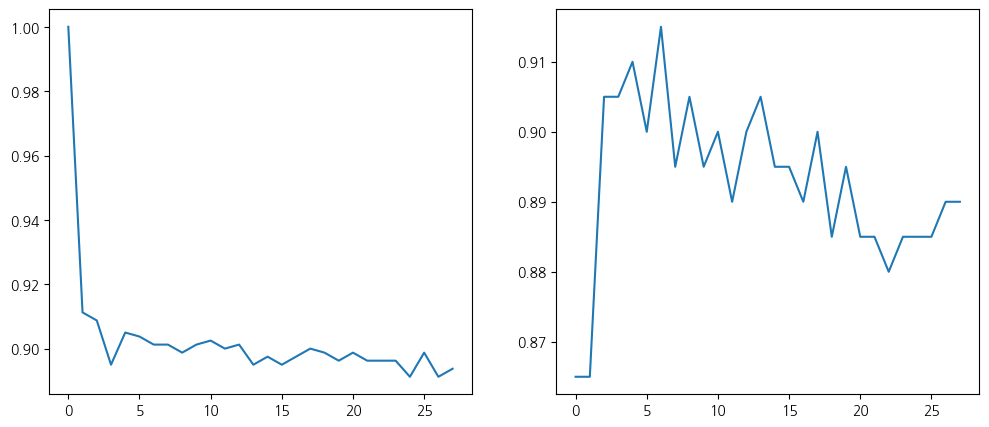

In [10]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
axes[0].plot(df['공부용 테스트'])
axes[1].plot(df['테스트용 테스트'])
plt.show()

In [11]:
## [4-1] 모델 인스턴스 생성
print(BEST_K)
kModel = KNeighborsClassifier(n_neighbors=BEST_K)
kModel

7


,n_neighbors,7
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [12]:
## [4-2] 학습 진행 => 학습용 데이터셋만 사용
## 주의 : .fit(2D_피쳐, 1D_타겟)
kModel.fit(s_x_train, y_train)

,n_neighbors,7
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


[5] 성능평가 : 테스트용 데이터셋 진행 <hr>
- 학습용, 테스트용 성능 비교

In [13]:
## .score(2D_피쳐, 1D_타켓)
train_score = kModel.score(s_x_train, y_train)
test_score = kModel.score(s_x_test, y_test)

print(f'[성능비교]\n학습 점수 : {train_score} *테스트 점수 : {test_score}')

[성능비교]
학습 점수 : 0.90125 *테스트 점수 : 0.915


[6] 일반적인 데이터 예측 서비스 <hr>
- ★★★ 반드시 데이터는 스케일링 후 진행

In [14]:
in_data = input('생선의 무게와 길이 입력(ex] 273 29)').strip().split()
in_data = list(map(float, in_data))
print(f'new_data : {in_data}', end=' ')

## DF 형식으로 저장
new_data = pd.DataFrame([in_data], columns=fishDF.columns[1:])

## 스케일링 징행
s_new_data = stdScaler.transform(new_data)
print(f'=> s_new_data : {s_new_data}')


new_data : [2.0, 2.0] => s_new_data : [[ -3.28884478 -10.03777555]]


In [15]:
## 예측 진행
## -> 예측한 타겟/라벨/클래스
pre_target = kModel.predict(s_new_data)
## -> 각 타겟/라벨/클래스의 확률값
proba_     = kModel.predict_proba(s_new_data)
print(proba_)
print(f'proba => Bream : {proba_[0][0]*100}%, Smelt : {proba_[0][1]*100}%')

print(f'무게 {in_data[0]}g, 길이 {in_data[1]}mm 생선은 {pre_target.item()}입니다.')

[[0. 1.]]
proba => Bream : 0.0%, Smelt : 100.0%
무게 2.0g, 길이 2.0mm 생선은 Smelt입니다.


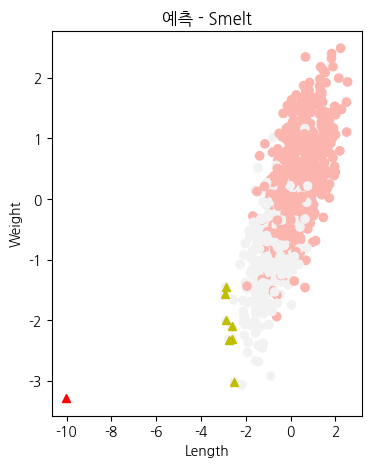

In [16]:
# 예측 검사
_, sIndices  = kModel.kneighbors(s_new_data)

## 시각화
plt.figure(figsize=(4,5))
plt.scatter(s_x_train[:, 1], s_x_train[:, 0], c=y_train.cat.codes, cmap='Pastel1')

#-> 새로운 데이터
plt.plot(s_new_data[0][1], s_new_data[0][0], '^r')

#-> 이웃 데이터
nIdx = sIndices[0].tolist()
for idx in nIdx:
    plt.plot(s_x_train[idx][1], s_x_train[idx][0], '^y')
    
plt.xlabel('Length')
plt.ylabel('Weight')
plt.title(f'예측 - {pre_target.item()}')
plt.show()